# Basic NMR examples - symbolic calculation

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import simos as sos

t, x, y, w0, w1, r, phi, theta, T1, T2 = sp.symbols('t x y omega_0 omega_1 r phi theta, T_1, T_2',real=True,positive=True)

SimOS allows to perform symbolic calculations with the `sympy` library. This is useful to understand the mathematical background of the NMR experiments. In this notebook, we will show some basic examples of symbolic calculations for NMR experiments.

## Rabi oscillations

The simplest example of NMR experiment is the Rabi oscillations. In this experiment, we apply a resonant RF pulse to a spin system and observe the oscillations of the magnetization. We define a symbolic spin system `s` with a single spin-1/2 nucleus:

In [ ]:
system_def = []
system_def.append({'name':'S','val':1/2})
s = sos.System(system_def,'sympy')

We go to the interaction frame (the rotating frame) and define our RF Hamiltonian:

In [ ]:
H1 = w1*s.Sx
H1

Matrix([
[        0, omega_1/2],
[omega_1/2,         0]])

We can now calculate the time evolution operator $U$ for a given time $t$:

In [ ]:
U = sp.simplify(sos.evol(H1,t))
U

Matrix([
[   cos(omega_1*t/2), -I*sin(omega_1*t/2)],
[-I*sin(omega_1*t/2),    cos(omega_1*t/2)]])

We can now peform the experiment: First we initialize our spin in the $|-1/2\rangle$ state, then we apply the RF Hamiltonian for a time $t$ and finally we measure the expectation value the overlap with the initial state:

In [ ]:
rho0 = s.Sp[-1/2]
rho = sos.evol(H1,t,rho0)
meas = sp.simplify(sos.expect(rho0,rho))
meas

cos(omega_1*t/2)**2

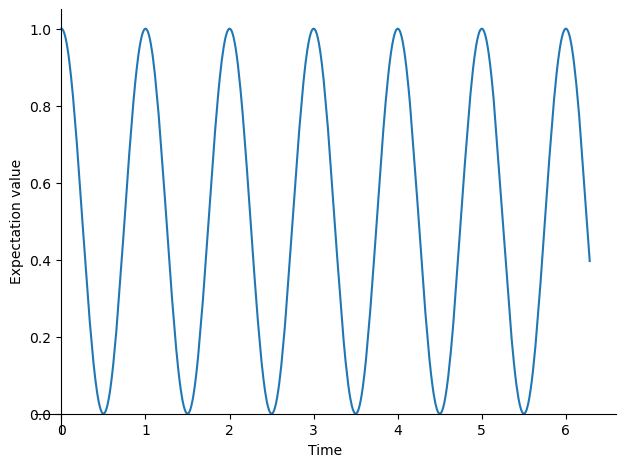

In [ ]:
# Plot with w1 = 2*pi
sp.plot(meas.subs({w1:2*sp.pi}), (t,0,2*sp.pi), ylabel='Expectation value', xlabel='Time')
plt.show()

You can use the `ipywidgets` library to interactively plot the Rabi oscillations:

In [ ]:
def plot(factor):
    w1_val = 2*np.pi*factor
    meas_evaluated = meas.subs({w1:w1_val})
    sp.plot(meas_evaluated, (t,0,2*sp.pi), ylabel='Expectation value', xlabel='Time',ylim=(0,1))

ipywidgets.interact(plot, factor=(0.1,2,0.1,))

interactive(children=(FloatSlider(value=1.0, description='factor', max=2.0, min=0.1), Output()), _dom_classes=…

<function __main__.plot(factor)>

## Magnetization decay

To demonstrate incoherent evolution in the simplest possible way, we consider an out-of-equilibrium magentization decay experiment. In this experiment, we simply wait for a time $t$ and then measure the magnetization. We assume that we work in the infinite temperature limit:

In [ ]:
system_def = []
system_def.append({'name':'S','val':1/2,'T1':T1})
s = sos.System(system_def,'sympy')

In [ ]:
rho0 = s.Sp[-1/2]
c_ops = sos.relaxation_operators(s)

# Experiment
rho = rho0.copy()
rho = sos.evol(s.id*0,t,rho,c_ops=c_ops)
meas = sp.simplify(sos.expect(s.Sz,rho))

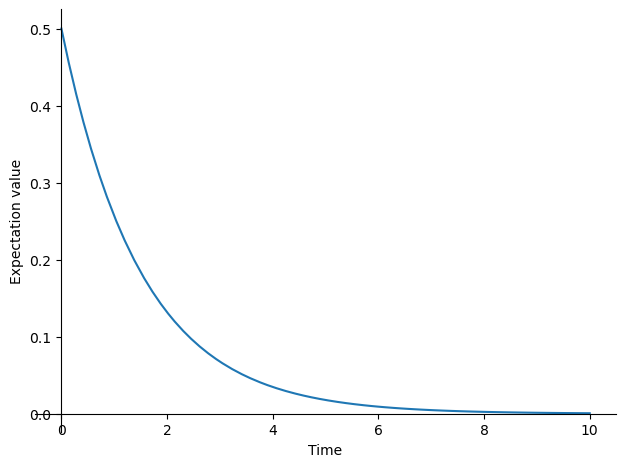

In [ ]:
# Plot with w1 = 2*pi
sp.plot(meas.subs({T1:1.5}), (t,0,10),ylabel='Expectation value', xlabel='Time')

In [ ]:
rho.simplify()

Matrix([
[1/2 + exp(-t/T_1)/2,                   0],
[                  0, 1/2 - exp(-t/T_1)/2]])

In [ ]:
meas.simplify()

exp(-t/T_1)/2

## FID experiment

To demonstrate incoherent evolution in a simple way, we will consider a Free Induction Decay experiment. In this experiment, we apply a $\pi/2$ pulse to induce precession of the magnetization, wait for a time $t$ and then measure the coherence. We assume that we work in the infinite temperature limit:

In [ ]:
system_def = []
system_def.append({'name':'S','val':1/2,'T2':T2})
s = sos.System(system_def,'sympy')

In [ ]:
rho0 = s.Sp[-1/2]
c_ops = sos.relaxation_operators(s)

# Experiment
rho = rho0.copy()
rho = sos.rot(s.Sx,sp.pi/2,rho)
rho1 = rho.copy()
rho = sos.evol(s.Sz*w0,t,rho,c_ops=c_ops)
meas = sp.simplify(sos.expect(s.Sy,rho))

In [ ]:
sp.expand(meas, complex=True).simplify()

exp(-t/T_2)*cos(omega_0*t)/2

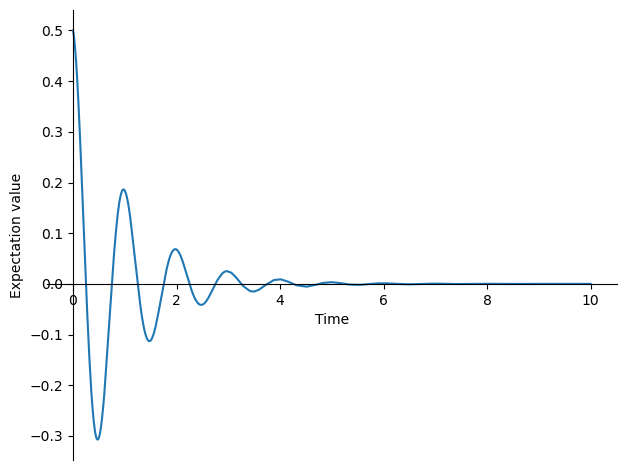

In [ ]:
sp.plot(meas.subs({T2:1,w0:2*sp.pi}), (t,0,10),ylabel='Expectation value', xlabel='Time')

## DEER / PELDOR experiment

Finally, we demonstrate multi-spin experiments with the DEER / PELDOR experiment. In this experiment, we apply a $\pi/2$ pulse to the first spin and wait for a time $t/2$. Now, we invert both spins with a $\pi$ pulse and wait for another time $t/2$. Finally, we apply another $\pi/2$ pulse to the first spin and measure the expectation value of the $S_z$ operator. We assume a dipolar coupling between the two spins:

In [ ]:
system_def = []
system_def.append({'name':'S','val':1/2})
system_def.append({'name':'I','val':1/2})
s = sos.System(system_def,'sympy')

r = sp.Symbol('r',real=True,positive=True)

H0 = sos.dipolar_coupling(s,'S','I',1,1,r,theta,phi,approx='secular')	
H0 = sp.simplify(H0)
H0

Matrix([
[hbar*mu0*(3*sin(theta)**2 - 2)/(16*pi*r**3),                                           0,                                           0,                                           0],
[                                          0, hbar*mu0*(2 - 3*sin(theta)**2)/(16*pi*r**3),                                           0,                                           0],
[                                          0,                                           0, hbar*mu0*(2 - 3*sin(theta)**2)/(16*pi*r**3),                                           0],
[                                          0,                                           0,                                           0, hbar*mu0*(3*sin(theta)**2 - 2)/(16*pi*r**3)]])

To make the expressions easier to read, we replace all unwanted constants:

In [ ]:
Hsimple = sos.symbolic_replace_all(H0,1,r,theta)
Hsimple

Matrix([
[(3*sin(theta)**2 - 2)/(16*pi*r**3),                                  0,                                  0,                                  0],
[                                 0, (2 - 3*sin(theta)**2)/(16*pi*r**3),                                  0,                                  0],
[                                 0,                                  0, (2 - 3*sin(theta)**2)/(16*pi*r**3),                                  0],
[                                 0,                                  0,                                  0, (3*sin(theta)**2 - 2)/(16*pi*r**3)]])

The initial state is:

In [ ]:
rho0 = s.Sp[-1/2]*s.Ip[-1/2]
rho0

Matrix([
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

Since we need the time evolution operator for the dipolar coupling twice, we calculate it and store it in a variable:

In [ ]:
Ut = sos.evol(Hsimple,t/2)

Now, we run the DEER sequence:

In [ ]:
rho = rho0.copy()
rho = sos.rot(s.Sx,sp.pi/2,rho)

rho = Ut*rho*Ut.dag()

rho = sos.rot(s.Sy,sp.pi,rho)
rho = sos.rot(s.Iy,sp.pi,rho)

rho = Ut*rho*Ut.dag()

rho = sos.rot(s.Sx,-sp.pi/2,rho)

In [ ]:
meas = sos.expect(s.Sz,rho)
sp.expand(sp.simplify(2*meas),complex=True)

cos(3*t*sin(theta)**2/(8*pi*r**3) - t/(4*pi*r**3))

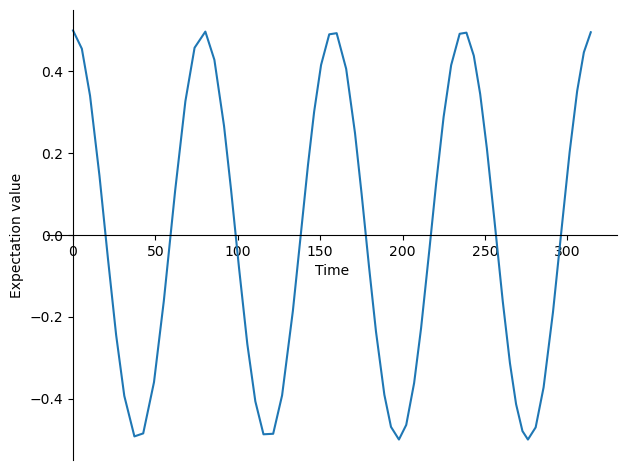

In [ ]:
meas1 = meas.subs({theta:0,r:1})
sp.plot(meas1, (t,0,100*sp.pi), ylabel='Expectation value', xlabel='Time')